CS235 Project - Fall 2024
- Alex Cupps (acupp002)
- Zach Schwartz (zschw004)

In [3]:
#Cell reserved for all needed imports
import numpy as np
import pandas as pd
import math
from collections import Counter
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors


Before we begin to analyze our data, we must first load it from the .data file provided, along with assigning the column names for the respective features:

In [4]:
columns = ['ID',
           'Diagnosis',
           'radius1',
           'texture1',
           'perimeter1',
           'area1',
           'smoothness1',
           'compactness1',
           'concavity1',
           'concave_points1',
           'symmetry1',
           'fractal_dimension1',
           'radius2',
           'texture2',
           'perimeter2',
           'area2',
           'smoothness2',
           'compactness2',
           'concavity2',
           'concave_points2',
           'symmetry2',
           'fractal_dimension2',
           'radius3',
           'texture3',
           'perimeter3',
           'area3',
           'smoothness3',
           'compactness3',
           'concavity3',
           'concave_points3',
           'symmetry3',
           'fractal_dimension3'
           ]

data = pd.read_csv('data/wdbc.data', header=None, sep=',', names=columns)
print(data.head())


         ID Diagnosis  radius1  texture1  perimeter1   area1  smoothness1  \
0    842302         M    17.99     10.38      122.80  1001.0      0.11840   
1    842517         M    20.57     17.77      132.90  1326.0      0.08474   
2  84300903         M    19.69     21.25      130.00  1203.0      0.10960   
3  84348301         M    11.42     20.38       77.58   386.1      0.14250   
4  84358402         M    20.29     14.34      135.10  1297.0      0.10030   

   compactness1  concavity1  concave_points1  ...  radius3  texture3  \
0       0.27760      0.3001          0.14710  ...    25.38     17.33   
1       0.07864      0.0869          0.07017  ...    24.99     23.41   
2       0.15990      0.1974          0.12790  ...    23.57     25.53   
3       0.28390      0.2414          0.10520  ...    14.91     26.50   
4       0.13280      0.1980          0.10430  ...    22.54     16.67   

   perimeter3   area3  smoothness3  compactness3  concavity3  concave_points3  \
0      184.60  2019.0  

<h2>1. Implementing simple classifiers [15pts]</h2>
- What to implement: In this question you should implement (1) a decision tree classifier
that uses the Information Gain splitting criterion and (2) a Naive Bayes classifier which uses
Gaussian modeling for continuous features.
- What to plot: You should produce a bar-chart that shows the performance of your classifiers
on the dataset.


We will be creating a decision tree classifier using the information gain splitting criterion to effectively utilize the feature at each node that provides us with the most information gain about our target feature, 'Diagnosis' - telling us whether or not a breast mass is malignant (M) or benign (B). 
<br><br>
First, we must prepare the data for the decision tree. First, we will drop the ID column and data from our dataset, as this data is not relevant to our predictive model. Next, we will create two new variables:
1. features - the data for all features in our dataset other than the target
2. target - the target feature of our dataset (Diagnosis) - determining whether a tumor is benign or malignant. We will convert the diagnosis data from categorical to numerical for the decision tree classifier.

In [5]:

if 'ID' in data.columns:
    data = data.drop(columns=['ID'])
    
features = data.drop(columns=['Diagnosis']).values
target = data['Diagnosis'].map({'M': 1, 'B': 0}).values

Next, we will create a function 'calculate_entropy' that takes the various values in the dataset and calculate the entropy, or level of purity.

In [6]:
def calculate_entropy(x):
    counts = np.bincount(x)
    probabilities = counts / len(x)
    entropy = 0

    for prob in probabilities:
        if prob > 0:
            entropy += prob * abs(np.log2(prob))

    return entropy

Now that we have our entropy calculation completed, we need to create a function for calculating information gain. Since our features are mainly continuous, we should not perform exact value splits - doing so would lead to many small (and mostly single-item) bins, which would result in overfitting of our model. Instead, we will come up with thresholds between values for our splitting.

In [7]:
def calculate_information_gain(dataset, labels, feature):
    
    #sort the indexes of the dataset for the given feature
    sorted = np.argsort(dataset[:, feature])

    #apply the sorting to the feature data and labels
    sorted_data = dataset[sorted]
    sorted_labels = labels[sorted]

    #start at the top, calculating entropy level of the dataset
    #to determine the level of purity
    parent_entropy = calculate_entropy(labels)

    #iterate over possible thresholds and get the indexes on each side
    top_info_gain = 0
    top_threshold = None
    for i in range(1, len(sorted_data)):

        threshold = (sorted_data[i-1, feature] + sorted_data[i, feature]) / 2
        #left split is a boolean array containing True for the indexes with a value less than the threshold
        #right split is a boolean array containing True for the indexes with a value greater than or equal to the threshold
        left_split = sorted_data[:, feature] < threshold
        right_split = sorted_data[:, feature] >= threshold

        #next we calculate the entropies for the left and right sides of the split
        #this will tell us how effective the split is, and we will maximize information gain
        left_split_entropy = calculate_entropy(sorted_labels[left_split])
        right_split_entropy = calculate_entropy(sorted_labels[right_split])

        #calculate the weights of the left and right splits for use in the overall weight entropy calculation
        weight_l = np.sum(left_split) / len(sorted_data)
        weight_r = np.sum(right_split) / len(sorted_data)

        #calculate the overall weighted entropy of the current split
        weighted_split_entropy = weight_l * left_split_entropy + weight_r * right_split_entropy

        #using the weighted split entropy, calculate the information gain of the threshold
        #if the information gain is higher than any we've come across thus far, set as the top one
        information_gain = parent_entropy - weighted_split_entropy
        if information_gain > top_info_gain:
            top_info_gain = information_gain
            top_threshold = threshold

    return top_info_gain, top_threshold

Now that we've created our functions to calculate entropy and weighted information gain, we will create the Decision Tree Classifier itself. First, we need to create a Node class to store various attributes (feature index, threshold, left of threshold values, right of threshold values) of the node we are evaluating:

In [8]:
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):

        #feature: index of feature being used for split
        self.feature = feature

        #threshold: threshold for the split
        self.threshold = threshold

        #left: the left node, contains all values < threshold
        self.left = left

        #right: the right node, contains all values >= threshold
        self.right = right

        #value: value (0 or 1 for benign or malignant) assigned when a leaf node is reached
        #remains None until leaf node is found, then returns the value
        self.value = value

    def leaf_node_reached(self):
        if self.value is not None:
            return True
        else:
            return False

Next, we will create our DecisionTreeClassifier class. This object contains all relevant methods for building our decision tree, recursively building tree nodes and calculating/maximizing information gain. I've annotated each method below with comments on its purpose: 

In [9]:
class DecisionTreeClassifier:
    def __init__(self, maximum_tree_depth):

        #maximum_tree_depth (int): the maximum depth for our tree
        self.maximum_tree_depth = maximum_tree_depth

        self.tree = None

    def fit(self, dataset, labels):
        #method containing all logic to train our classifier
        self.tree = self.build_tree(dataset, labels)

    def build_tree(self, dataset, labels, cur_tree_depth=0):
        #this method is where the bulk of the work is handled for building our decision tree

        #label count gives us the number of labels in the current sample set
        #label count of 1 indicates perfect purity (one of our stopping criteria)
        label_ct = len(np.unique(labels))

        #we first check our stoppage criteria, to see if we've reached a leaf node
        #if our current depth has hit the stoppage depth defined, OR
        #if the label count has a value of 1
        if cur_tree_depth >= self.maximum_tree_depth or label_ct == 1:
            #return leaf node with the most common class label
            leaf_value = self.get_top_label(labels)
            return TreeNode(value=leaf_value)

        #call get_top_split() to calculate the top feature and threshold
        top_feature, top_threshold = self.get_top_split(dataset, labels)
        if top_feature is None:
            #no feature being returned indicates we've reached a leaf node
            #return this TreeNode object with the leaf value found
            leaf_value = self.get_top_label(labels)
            return TreeNode(value=leaf_value)

        #split data on top feature and threshold
        #then build the sub trees off using this split
        left_split = dataset[:, top_feature] < top_threshold
        right_split = dataset[:, top_feature] >= top_threshold
        left_sub_tree = self.build_tree(dataset[left_split], labels[left_split], cur_tree_depth + 1)
        right_sub_tree = self.build_tree(dataset[right_split], labels[right_split], cur_tree_depth + 1)

        return TreeNode(feature=top_feature, threshold=top_threshold, left=left_sub_tree, right=right_sub_tree)

    def get_top_split(self, dataset, labels):

        feature_ct = dataset.shape[1]
        top_feature = None
        top_threshold = None
        top_info_gain = 0

        #iterate over the features and determine which feature/threshold provide the highest information gain
        for feature in range(feature_ct):
            info_gain, threshold = calculate_information_gain(dataset, labels, feature)
            if info_gain > top_info_gain:
                top_info_gain = info_gain
                top_feature = feature
                top_threshold = threshold

        return top_feature, top_threshold

    def get_top_label(self, labels):
        #returns the most common label in the array
        #we call this function to determine whether benign or malignant samples are more prominent
        return np.bincount(labels).argmax()

    def predict(self, dataset):
        predictions = []
        for point in dataset:
            #append the predicted label value to our predictions list
            predictions.append(self.predict_datapoint(point, self.tree))
        return np.array(predictions)

    def predict_datapoint(self, point, node):
        #first check if we've reached a leaf node
        #if so, return the determined label value
        if node.leaf_node_reached():
            return node.value
        
        #if not leaf value, continue down the left or right tree nodes
        if point[node.feature] < node.threshold:
            return self.predict_datapoint(point, node.left)
        else:
            return self.predict_datapoint(point, node.right)

    #required getter and setter functions for our object 
    def get_params(self, deep=True):
        return {"maximum_tree_depth": self.maximum_tree_depth}

    def set_params(self, maximum_tree_depth=None):
        self.maximum_tree_depth = maximum_tree_depth
        return self

The two main classes for our given dataset is Benign and Malignant.  The two classes will help separate the training data based on our target variable of 'Diagnosis'.  There are four methods defined for these two classes:

benign_data()/malignant_data(): The training data is spliced on whether an associated column contains 0 for benign or 1 for malignant.  This label encoding was established earlier to easily reference the two classes
mean(): calculates the mean of each feature
variance(): calculates variance of each feature
gaussianProbability(): assuming a normal Gaussian distribution, the probability of each feature in a data sample/instance.  The mean/variance calculated above is utilized within this method.  Feature probabilities are combined using logarithmic summation which is more stable at handling miniscule values.  Values of zero found in mean/variance were redefined as 1E-12 to avoid possibility of dividing by zero.  Similar logic is applied to the probability of a feature value being found in a class



In [10]:
#Separating the data by class 
class Benign:
    #Having benign data be instance method allows method to call on itself
    def benign_data(self, features, target):
        x_train_b = features[target == 0]
        return x_train_b
    
    def mean(self, x_train_b):
        mean_value = {}
        mean_value = np.mean(x_train_b, axis = 0)
        return mean_value
    def variance(self, x_train_b):
        variance = {}
        variance = np.var(x_train_b, axis = 0)
        return variance
    #Probability calculation requires parameters of class data set, index being called plus pre-calculated mean & variance
    
    def gaussianProbability(self, x_train_b, index, mean,variance):     
        #Defining the probability sum before loop so function can add up all probabilities through each run in loop
        sum_logP = 0
        #Loop will go through all the data points within the columns
        for feature_array in range(x_train_b.shape[1]):
         #After parsing through a feature, x captures the data sample/instance within index that is called
            x = x_train_b[index, feature_array]
            μ = mean[feature_array]
            σ = variance[feature_array]
            #Handling zero values to avoid breaking Gaussian Probability calculation
            if σ == 0:
                σ = 1E-12
            if μ ==0:
                μ = 1E-12
                #Setting up Naive Bayes proability calculation on continuous features by splitting numerator and denominator
                #Assumes dataset has a Gaussian Distribution
            num = math.exp(-(x-μ)**2/(2*σ))
            denom = math.sqrt(2 * math.pi * σ)
            P = num/denom
                #Ensuring probability will not get too close to 0
            if P <= 0:
                P = 1E-18
                #Using summation o
                #Using summation of log function over product of posterior probability since log handles small numbers better
            logP= (math.log(P))
                #Variable increases the count of logP
            sum_logP += logP
        return sum_logP


class Malignant:
    def malignant_data(self, features, target):
        x_train_m = features[target == 1]
        return x_train_m
    
    def mean(self, x_train_m):
        mean_value = {}
        #Calculating mean of the numerical features in dataset
        mean_value = np.mean(x_train_m, axis = 0)
        return mean_value
    def variance(self, x_train_m):
        variance = {}
        #Calculating variance of numerical features in databset
            #Recording the variance value for each individual feature
        variance = np.var(x_train_m, axis = 0)
        return variance
    #Probability calculation requires parameters of class data set, index being called plus pre-calculated mean & variance
    def gaussianProbability(self, x_train_m, index, mean,variance):     
        #Defining the probability sum before loop so function can add up all probabilities through each run in loop
        sum_logP = 0
         #Loop will go through all the data points within the columns
        for feature_array in range(x_train_m.shape[1]):
         #After parsing through a feature, x captures the data sample/instance within index that is called
            x = x_train_m[index, feature_array]
            μ = mean[feature_array]
            σ = variance[feature_array]
            #Handling zero values to avoid breaking Gaussian Probability calculation
            if σ == 0:
                σ = 1E-12
            if μ ==0:
                μ = 1E-12
                #Setting up Naive Bayes proability calculation on continuous features by splitting numerator and denominator
                #Assumes dataset has a Gaussian Distribution
            num = math.exp(-(x-μ)**2/(2*σ))
            denom = math.sqrt(2 * math.pi * σ)
            P = num/denom
                #Ensuring probability will not get too close to 0
            if P <= 0:
                P = 1E-18
                #Using summation o
                #Using summation of log function over product of posterior probability since log handles small numbers better
            logP= (math.log(P))
                #Variable increases the count of logP
            sum_logP += logP
        return sum_logP
    


A split of the features into training and testing data is employed shortly before fitting the Naive Bayes model.  Using same exact dataset to fit and test performance of model presents a risk of overfitting to this particular dataset.  Dividing the features allows a more holisitic evaluation of the model

In [11]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)


Next, we create a NaiveBayesClassifier object to help us classify our data samples as benign or malignant. Below is a breakdown of the class:

- init(): initialize the object
- fit(): the method for training our NB classifier. In this method, we calculate the prior probabilities for both malignant and benign label values. We then train the classifier based off of these prior beliefs, and calculate the mean and variance values for both the malignant and benign labels.
- predict(): in this method, we compute the actual prediction value of the label for a given row of data in our test split dataset. We calculate the Gaussian probability for each class label (B vs. M). Whichever one is higher is the predictive value we assign to the data.
- get_params() / set_params(): allows for getting and setting of the object's values dynamically. These two methods are required in order to work with SKLearn's cross_val_score function that we utilize in order to calculate the performance of our model (without these two methods, errors are thrown when trying to call the function).


In [12]:
class NaiveBayesClassifier:
    def __init__(self, priors=None):
        self.benign = Benign()
        self.malignant = Malignant()
        self.priors = priors if priors is not None else {}

    def fit(self, x_train, y_train):
        n_total = len(y_train)
        n_benign = np.sum(y_train== 0)
        n_malignant = np.sum(y_train == 1)
        self.priors['benign'] = n_benign / n_total
        self.priors['malignant'] = n_malignant / n_total
        self.x_train_b = self.benign.benign_data(x_train, y_train)
        self.mean_b = self.benign.mean(self.x_train_b)
        self.variance_b = self.benign.variance(self.x_train_b)

        self.x_train_m = self.malignant.malignant_data(x_train, y_train)
        self.mean_m = self.malignant.mean(self.x_train_m)
        self.variance_m = self.malignant.variance(self.x_train_m)

    def predict(self, x_test):
            
        predictions = []

        for index in range(len(x_test)):
            #Compute probabilities, and assign the predicted class of 0 (benign) or 1 (malignant)
            #depending on which probability is higher
            gauss_test_B = self.benign.gaussianProbability(x_test, index, self.mean_b, self.variance_b)
            gauss_test_M = self.malignant.gaussianProbability(x_test, index, self.mean_m, self.variance_m)
            pred_class = 0 if gauss_test_B > gauss_test_M else 1
            predictions.append(pred_class)

        return np.array(predictions)

    def get_params(self, deep=True):
        return {'priors': self.priors}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


Now that we've created our decision tree and naive bayes classifiers, we will begin the process of testing the performance and analyzing our results. Below, we've created two functions:

1. test_performance() - this function has two arguments, X (the data matrix) and y (the label values). 
2. get_f1() - a helper function called by our test_performance function. This function takes four arguments - the data matrix and label values passed in from test_performance, along with the stratified k fold and classifier objects we've created. We return sklearn's cross_val_score call on our parameters, which returns an array containing the f1 scores at each fold in the cross validation.

In [13]:
def test_performance(classifier, X, y,num_splits):
    kfold = StratifiedKFold(n_splits=num_splits, shuffle=True)
    f1_scores = get_f1(X, y, kfold, classifier)

    mean_f1_scores = np.mean(f1_scores)
    stdev_f1_scores = np.std(f1_scores)

    return mean_f1_scores, stdev_f1_scores

def get_f1(X, y, skf, classifier):
    return cross_val_score(classifier, X, y, cv=skf, scoring=make_scorer(f1_score, average='weighted'))

Once we've built our performance calculating functions, we want to plot our results. We call test_performance, and get the mean and standard deviation values of our f1 scores at each fold, for both of our classifiers. With these two values, we build up a plot to show each classifier's performance, along with the levels of error:

Decision Tree F1 Mean: 0.9432770640866762
Decision Tree F1 Std. Dev.: 0.03217758070612981
Naive Bayes F1 Mean: 0.9277290007325311
Naive Bayes F1 Std. Dev.: 0.03958043105259469


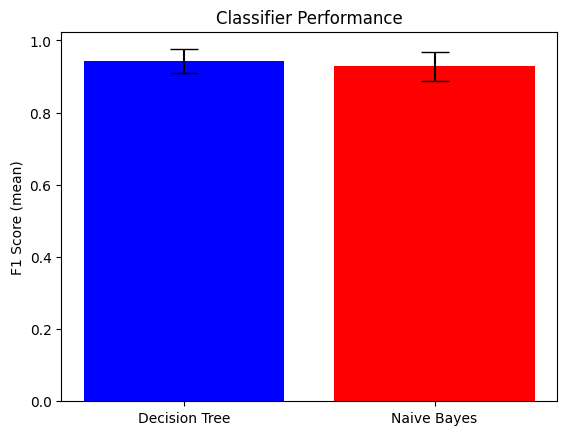

In [14]:
def plot_performance(classifier_names, mean_f1, std_f1):
    fig, ax = plt.subplots()
    ax.bar(classifier_names, mean_f1, yerr=std_f1, color=['blue', 'red'], capsize=10)
    ax.set_ylabel('F1 Score (mean)')
    ax.set_title('Classifier Performance')
    plt.show()

dec_tree_mean_f1, dec_tree_std_f1 = test_performance(
    DecisionTreeClassifier(maximum_tree_depth=5), 
    features, 
    target, 
    10)

nb_mean_f1, nb_std_f1 = test_performance(
    NaiveBayesClassifier(), 
    features, 
    target,
    10)

print(f"Decision Tree F1 Mean: {dec_tree_mean_f1}")
print(f"Decision Tree F1 Std. Dev.: {dec_tree_std_f1}")
print(f"Naive Bayes F1 Mean: {nb_mean_f1}")
print(f"Naive Bayes F1 Std. Dev.: {nb_std_f1}")

classifier_names = ["Decision Tree", "Naive Bayes"]
f1_means = [dec_tree_mean_f1, nb_mean_f1]
f1_stds = [dec_tree_std_f1, nb_std_f1]

plot_performance(classifier_names, f1_means, f1_stds)

Based on these results, we can see that both the decision tree classifier and the Naive Bayes classifier are performing well, with around a 0.94 and 0.93 mean F1 score respectively, which indicates our classifiers are effectively handling our imbalanced dataset and considering false positives and false negatives. The low standard deviation for decision tree model (roughly 0.03) tells us that the classifier are avoiding overfitting the data and performing well across the ten folds.  The Naive Bayes is also performing well, with a standard deviation of 0.04.

<h2>2. Dimensionality reduction with the Singular Value Decomposition [10pts]</h2>
What to implement: The Singular Value Decomposition (SVD) is an extremely useful tool
from linear algebra that can help us approximate a data matrix (such as the instance-by-feature matrix that represents our data) into a smaller dimension, hence reduce the dimensionality of the data. In this question you should use the SVD (you may use the existing NumPy library) to approximate the data in different ranks. Important: because we are dealing with supervised learning, given a train/test split, in order to avoid data leakage you should always make sure that you only compute the SVD on the train split and project the test instances to that space, in the same way that the Latent Semantic Analysis paper [1] does.
<br><br>
What to plot: You should produce a figure that shows the performance of your classifiers as
a function of the SVD approximation rank

In [15]:
#first, we split our data using train/test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

#then, utilize numpy's singluar value decomposition function on only our training split
#this decomposes our training data matrix into three separate matrices
U, S, Vh = np.linalg.svd(X_train)

#create reduce() function with the following parameters:
#U: the orthonormal columns of our data
#S: the diagonal matrix of our data
#Vh: the orthonormal rows of our data
#rank: the rank we use to approximate the data 
def reduce(U, S, Vh, rank):
    #reduce each of our three matrices based on the rank passed in
    reduced_U = U[:, :rank]
    reduced_S = np.diag(S[:rank])
    reduced_Vh = Vh[:rank, :]

    #multiply the reduced versions of U and S to get the reduced version of our original training data matrix
    reduced_train_data = np.dot(reduced_U, reduced_S)
    
    return reduced_train_data

Once we've written our code for reducing the based on the top number of singular values and vectors (our 'rank'), we now want to create a helper function to project the test data split based on reduced space we created with the SVD functionality:

In [16]:
def project_test(test_data, transpose_matrix):
    return np.dot(test_data, transpose_matrix)

Next, we want to create another helper function to evlauate our decision tree and naive bayes classifiers on the projected test data in the reduced space:

In [17]:
def evaluate(X_train_reduced, X_test_reduced, y_train, y_test):
    
    #initialize the decision tree classifier obj and NB classifier obj
    dec_tree = DecisionTreeClassifier(maximum_tree_depth=5)
    nb = NaiveBayesClassifier()

    #calculate the performance of each classifier using the helper function
    #test_performance() that we created earlier along in the project
    dec_tree_mean_f1, dec_tree_stdev_f1 = test_performance(dec_tree, X_train_reduced, y_train,10)
    nb_mean_f1, nb_stdev_f1 = test_performance(nb, X_train_reduced, y_train,10)

    print(f"dec_tree_mean_f1: {dec_tree_mean_f1}")
    print(f"dec_tree_stdev_f1: {dec_tree_stdev_f1}")
    print(f"nb_mean_f1: {nb_mean_f1}")
    print(f"nb_stdev_f1: {nb_stdev_f1}")

    #only returning the mean values since these are what we're plotting on our SVD approx. graph
    return dec_tree_mean_f1, nb_mean_f1

Once we've created our evaluate function, we can begin evaluating the performance of each of our classifiers across different ranks (or number of utilized features). For sake of performance, we've gone ahead and created a ranks list containing intervals of 5 up to 30, the total number of features we have originally. <br><br>
We iterate over each rank, evaluate our classifiers performance at each once, then create a plot displaying the respective mean F1 scores for each classifier.

---------------
Rank -5-
X_train_reduced shape -(426, 5)-
X_test_reduced shape -(143, 5)-
dec_tree_mean_f1: 0.9104206872438588
dec_tree_stdev_f1: 0.03823198012300525
nb_mean_f1: 0.9022207349669191
nb_stdev_f1: 0.04184435284867363
---------------
Rank -10-
X_train_reduced shape -(426, 10)-
X_test_reduced shape -(143, 10)-
dec_tree_mean_f1: 0.9157153426999723
dec_tree_stdev_f1: 0.05139132316443236
nb_mean_f1: 0.9173701018936384
nb_stdev_f1: 0.0243600674807073
---------------
Rank -15-
X_train_reduced shape -(426, 15)-
X_test_reduced shape -(143, 15)-
dec_tree_mean_f1: 0.9152205895555827
dec_tree_stdev_f1: 0.034480715032952684
nb_mean_f1: 0.9053968255503486
nb_stdev_f1: 0.040358991768139
---------------
Rank -20-
X_train_reduced shape -(426, 20)-
X_test_reduced shape -(143, 20)-
dec_tree_mean_f1: 0.9221947460679274
dec_tree_stdev_f1: 0.04939382175308931
nb_mean_f1: 0.9081913703401799
nb_stdev_f1: 0.05433439539582776
---------------
Rank -25-
X_train_reduced shape -(426, 25)-
X_test_reduce

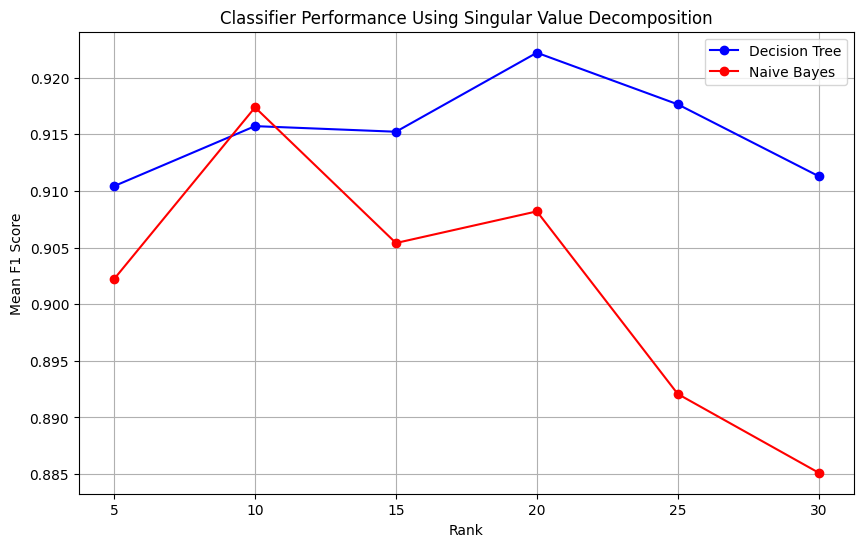

In [18]:
rank_list = [5, 10, 15, 20, 25, 30]
dec_tree_f1_per_rank = []
nb_f1_per_rank = []

for rank in rank_list:
    #reduce the training data using SVD
    X_train_reduced = reduce(U, S, Vh, rank)
    
    #reduce the test data to match the training data
    Vh_reduced = Vh[:rank, :]
    X_test_reduced = project_test(X_test, np.transpose(Vh_reduced))

    print("---------------")
    print(f"Rank -{rank}-")
    print(f"X_train_reduced shape -{X_train_reduced.shape}-") 
    print(f"X_test_reduced shape -{X_test_reduced.shape}-")

    scaler = StandardScaler()
    X_train_reduced = scaler.fit_transform(X_train_reduced)
    X_test_reduced = scaler.transform(X_test_reduced)
    
    #evaluate our classifier performances on the reduced train and test data
    dec_tree_f1, nb_f1 = evaluate(X_train_reduced, X_test_reduced, y_train, y_test)
    dec_tree_f1_per_rank.append(dec_tree_f1)
    nb_f1_per_rank.append(nb_f1)

plt.figure(figsize=(10, 6))
plt.plot(rank_list, dec_tree_f1_per_rank, label='Decision Tree', marker='o', color='blue')
plt.plot(rank_list, nb_f1_per_rank, label='Naive Bayes', marker='o', color='red')
plt.xlabel('Rank')
plt.ylabel('Mean F1 Score')
plt.title('Classifier Performance Using Singular Value Decomposition')
plt.legend()
plt.grid(True)
plt.show()


Given the graph above, we can see our mean F1 scores for the decision tree and Naive Bayes classifiers differ depending on the number of features utilized when training. We believe the steady decline in mean F1 score for the NB classifier could potentially be attributed to its assumption of independence between each feature, therefore struggling as more features are added. On the flip side, the DT classifier is able to maintain a higher mean F1 with more features, as it does a better job capturing and understanding complex feature interactions and dependencies.

<h2>3. Feature selection with randomization [15pts]</h2>

What to implement: Randomization is a very powerful tool in helping us understand whether a piece of data contains useful information for a given task or whether the information contained is close to random. In this question you should implement the following feature selection technique which randomizes each feature of the data and measures how predictive it is for our task. In order to avoid data leakage, for this question only you should conduct the feature selection on a 20% stratified random sample of the entire dataset, leaving the rest 80as the data on which you will report the performance on your plot.
<br>
• For every feature, generate a copy of the dataset where that feature values are randomized (i.e., randomly permuted)
<br>
• Train two versions of the model, one with the actual data and one with the data that contains the randomized feature.
<br>
• Test on part of the hold out that is for validation and use the difference in performance as a score for that feature.
<br>
• Steps b and c should be done as part of 5-fold cross-validation train/test splits on the feature selection sample and produce an average F1 score for each of the two models (regular and “randomized feature”)
<br>
• If randomization of the feature results in a drop of performance, the percentage of the drop can be used to characterize how important this feature is for the task
<br>
• Repeat for all features and rank features according to the above metric, from most pre- dictive to least predictive 
<br>
What to plot (2 figures in total): A bar chart that shows each feature and the calculated importance.

The permutatingColumn method takes a copy of original dataset and randomly permutates a column with the excpetion of target column 'Diagnosis'.  The column that was randomly permutated gets returned.  

In [19]:
#Creating a copy of original dataset for random permutation

#Method that loops through all columns and randomly permutates each feature
def permutatingColumn(data,column_index, target_col_index):
    random_perm_data = data.copy()
    if column_index != target_col_index:
        random_perm_data[:, column_index] = np.random.permutation(random_perm_data[:, column_index])
    return random_perm_data


Splitting the datset to set up for model training.  As detailed in the instructions, one of the model trainings will follow our standard dataset while the second one incorporates 20% stratified random sampling and the remaining 80% for testing will consist purely of the original dataset.  In order to keep data consistent with the classifiers written from scratch, encoding of the target feature Diagnosis was applied on the randomly permutated dataset.  
- 20% of dataset is used to randomly shuffle all features
- 80% dataset is untouched and used for testing at the end

In [20]:
#Feature selection on the 20% stratified random sample of entire dataset

train_data, test_data = train_test_split(data, test_size=0.8, random_state=42, stratify=data['Diagnosis'])

Below is where we start training the model with the created method dual_model_performance.  Both Decision Tree & Naive Bayes classifier are evaluated on a five fold cross validation.  The dataset copy containing a randomly permutated column gets evaluated in the two classifiers alongside the original dataset for a baseline comparison.  A comparison dictionary is created at the end of this function containing the following keys:

- decisionTree_original: F1 mean of orignal dataset
- decisitonTree_random: F1 mean of randomly permutated feature dataset
- naiveBayes_original: F1 mean of orignal dataset
- naiveBayes_random: F1 mean of randomly permutated feature dataset
- decisionTree_difference: absolute value difference between F1 means of original and randomly permutated feature dataset
- naiveBayes_difference: absolute value difference between F1 means of original and randomly permutated feature dataset
- decisionTree_percentDrop: percent change exhibiting in Decision Tree classifier when one feature gets randomly permutated
- naiveBayes_percentDrop: percent change exhibiting in Naive Bayes classifier when one feature gets randomly permutated

In [23]:
#Creating method that evaluates and compares both models against OG & randomized datasets
def dual_model_performance(model1, model2, x_train, y_train, x_test, y_test, x_train_R, y_train_R, x_test_R, y_test_R):
    #Evaluating Decision Tree model on original dataset
    model1 = DecisionTreeClassifier(maximum_tree_depth=5)
    model1.fit(x_train, y_train)
    model1.build_tree(x_train, y_train, cur_tree_depth=0)
    dec_tree_mean_f1, dec_tree_std_f1 = test_performance(
        DecisionTreeClassifier(maximum_tree_depth=5), x_test, y_test, 5)
    
    #Evaluating Decision Tree model on randomly permutated dataset
    model_dt= DecisionTreeClassifier(maximum_tree_depth=5)
    model_dt.fit(x_train_R, y_train_R)
    model_dt.build_tree(x_train_R, y_train_R, cur_tree_depth=0)
    dt_mean_f1, dt_std_f1 = test_performance(
        DecisionTreeClassifier(maximum_tree_depth=5), x_test_R, y_test_R, 5)

    #Evaluating Naive Bayes on original dataset
    model2 = NaiveBayesClassifier()
    model2.fit(x_train, y_train)
    nb_mean_f1, nb_std_f1 = test_performance(
        NaiveBayesClassifier(), x_test, y_test, 5)
    
    #Evaluating Naive Bayes model on randomly permutated dataset
    model_nb = NaiveBayesClassifier()
    model_nb.fit(x_train_R, y_train_R)
    nB_mean_f1, nB_std_f1 = test_performance(
        NaiveBayesClassifier(), x_test_R, y_test_R,5)

#Generating a comparision dictionary to store results
    comparisonModels = { 
        'decisionTree_original': dec_tree_mean_f1, 
        'decisionTree_random': dt_mean_f1,
        'naiveBayes_original': nb_mean_f1,
        'naiveBayes_random': nB_mean_f1,
        'decisionTree_difference': abs(dec_tree_mean_f1 - dt_mean_f1),
        'naiveBayes_difference': abs(nb_mean_f1 - nB_mean_f1),
        'decisionTree_percentDrop' : (abs(dec_tree_mean_f1 - dt_mean_f1)/dec_tree_mean_f1) * 100,
        'naiveBayes_percentDrop' : (abs(nb_mean_f1 - nB_mean_f1)/nb_mean_f1) * 100
    }

    return comparisonModels


After establishing a method to evaluate performance of both datasets on the Decision Tree & Naive Bayes classifier, features pass through a loop where they individually will get randomly permutated to see how important they are to this dataset.  This code block is an intermediary section that helps set up the final couple codeblocks of ranked features.




rp_data variable represents the training data containing a randomly permutating column.  It utilizes one of the initial methods permutating columns to randomly permutate a column in the copied dataset.  The loop is set up to ensure all features will be the feature randomly permutated in the dataset copy.  rp_data later gets used as training data for the randomly permutated section.


feature_importanceScore dictionary is created that stores feature_index being tested and the percentDrop calculated for both classifiers

In [24]:
target_col_index = 0
feature_importanceScore = []
#Looping through the features indexes of all columns in training data
for feature_index in range(x_train.shape[1]):
    rp_data= permutatingColumn(x_train, feature_index, target_col_index)
    comparison = dual_model_performance(
        model1=DecisionTreeClassifier(maximum_tree_depth=5),
        model2=NaiveBayesClassifier(),
        x_train=x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        x_train_R=rp_data, y_train_R= y_train,
        x_test_R=x_test, y_test_R= y_test
    )
    feature_importanceScore.append({
        'feature_index': feature_index, 
        'percentDrop_DT': comparison.get('decisionTree_percentDrop'),
        'percentDrop_NB': comparison['naiveBayes_percentDrop']
    })


The features are sorted within method sortedFeatureImportance based on which randomly permutated features resulted in the biggest change in performance after being tested by the two classifiers.  

The sortedFeatures variable sorts the percent drop in performance of the two classifiers in descending order (reverse = True). Lambda function key helps iterate over all percent drops to arrange in descending order.
Each feature index is matched with the feature name based on column names assigned at the very beginning section of this code.  An offset of 2 is added since ID column got dropped due to not being a value add and 'Diagnosis' is the target feature not utilized in training data set.

After rankedFeatures is retunrned at end of method, two variables for Decision Tree & Naive Bayes Classiers are set up calling the top 5 indexes within the sortedFeatureImportance method to rank the top 5 features for each classifier

In [25]:
def sortedFeatureImportance(feature_importanceScore, columns, classifier):
    sorted_features = sorted(feature_importanceScore, key=lambda x: x[f'percentDrop_{classifier}'], reverse=True)
    rankedFeatures = []
    for feature in sorted_features:
        feature_index = feature['feature_index']
        #Adding 2 to skip Diagnosis & ID Columns
        feature_name = columns[feature_index + 2]
        percentDrop = feature[f'percentDrop_{classifier}']
        rankedFeatures.append((feature_name, percentDrop))
        print(f"Feature: \n {feature_name}, \n {classifier} Percent Drop: {feature[f'percentDrop_{classifier}']}")
    return rankedFeatures
featureRank_DT = sortedFeatureImportance(feature_importanceScore, columns, 'DT')[:5]
featureRank_NB = sortedFeatureImportance(feature_importanceScore, columns, 'NB')[:5]

Feature: 
 fractal_dimension3, 
 DT Percent Drop: 7.250278696515262
Feature: 
 radius3, 
 DT Percent Drop: 4.626060415950064
Feature: 
 area1, 
 DT Percent Drop: 4.055041431111943
Feature: 
 perimeter2, 
 DT Percent Drop: 3.07673207128074
Feature: 
 radius1, 
 DT Percent Drop: 3.0433352190877856
Feature: 
 compactness1, 
 DT Percent Drop: 2.891890749936903
Feature: 
 fractal_dimension2, 
 DT Percent Drop: 2.847094258514947
Feature: 
 symmetry3, 
 DT Percent Drop: 2.3578225712189296
Feature: 
 symmetry2, 
 DT Percent Drop: 2.20079524528194
Feature: 
 concavity1, 
 DT Percent Drop: 2.1999588112718165
Feature: 
 area3, 
 DT Percent Drop: 2.150338479130514
Feature: 
 compactness3, 
 DT Percent Drop: 2.103753023030102
Feature: 
 concave_points2, 
 DT Percent Drop: 2.085543631487416
Feature: 
 texture2, 
 DT Percent Drop: 1.5399272955480618
Feature: 
 perimeter3, 
 DT Percent Drop: 1.5225434055640352
Feature: 
 concavity2, 
 DT Percent Drop: 1.4850917409976725
Feature: 
 smoothness3, 
 DT Pe

The top 5 features for Decision Tree Classifier are plotted in a bar char below.  

**x-axis: topFeatures** extracts the feature names from arrays featureRank_DT & featureRank_NB established in last cell

**y-axis: importance** extracts the percent drop (or importance %) in the second column of array featureRank_DT & featureRank_NB

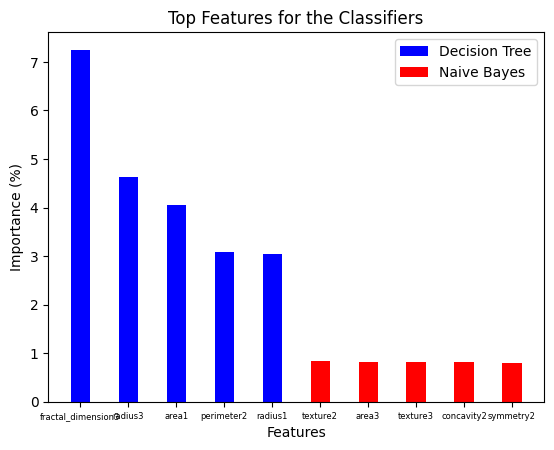

In [26]:
#Top Features for both classifiers
topFeaturesDT = [feature[0] for feature in featureRank_DT]
importanceDT = [feature[1] for feature in featureRank_DT]
topFeaturesNB = [feature[0] for feature in featureRank_NB]
importanceNB = [feature[1] for feature in featureRank_NB]

fig,ax = plt.subplots()
ax.bar(topFeaturesDT, importanceDT, width = 0.4 , align='center', color = 'blue', label = 'Decision Tree')
ax.bar(topFeaturesNB, importanceNB, width =0.4, align='center', color = 'red', label = 'Naive Bayes')
plt.title('Top Features for the Classifiers')
ax.set_xlabel('Features')
plt.xticks(fontsize = 6)
ax.set_ylabel('Importance (%)')
ax.legend()
plt.show()

The top 5 features most important to the dataset from Decision Tree classifier evaluation are: fractal_dimension3, radius3, area1, perimeter2 & radius1. All five feature show at least a 3% performance drop when their column is randomly permutated.  These features are all size based, showing that Decision tree classifier heavily relies on dimensional characteristics to be an effective model

Compared to Decision Tree model, Naive Bayes model shows to rely less on specific features.  No feature in dataset showed more than 1% performance drop when it was randomly permutated and tested on Naive Bayes classifier.  This makes sense since Naive Bayes should be established to assume feature independence.  The top five features have fairly similar performance drops, showing little reliance on any specific feature.  All five features - texture2, area3, texture3, concavity2, symmetry2 have importance percentage hovering around 0.8% showing their feature independence compared to decision tree model

<h2>4. Data augmentation using SMOTE [10pts]</h2>

What to implement: As we saw in class, SMOTE is one of the earliest and very successful data augmentation (or minority class oversampling) techniques. You can use the pseudocode included in the original SMOTE paper [2] as a basis for your implementation.<br><br>
What to plot: The performance of your classifiers as a function of the percentage of oversampled minority samples (100%, 200%, 300%) for k = 1, and k = 5. This plot should contain 2 lines per classifier (one for each k)

To perform our SMOTE implementation, first we created a function to figure out what the minority class is in the sample. This function get_minority() returns the minority label for benign or malignant (as 0 or 1) along with the indices of these minority records:

In [27]:
def identify_minority(sample):

    label_counts = Counter(sample)
    minority_label = min(label_counts, key=label_counts.get)
    minority_indices = np.where(sample == minority_label)[0]
    return minority_label, minority_indices

Next, we create a function to get the K nearest neighbors to the minority samples:

In [28]:
def get_nn(min_samples, k_neighbors):
    nn = NearestNeighbors(n_neighbors=k_neighbors).fit(min_samples)
    return nn.kneighbors(min_samples, return_distance=False)

Then we create a function <b>create_synthetics</b> to generate the samples from our minority sample. We pass three parameters into this function: <br><br>
min_samples: the minority samples we want to generate the synthetic samples from<br><br>
neighbors: the neighbors we determined using our previous get_nn() function <br><br>
n: the number of synthetic samples we want to create


In [29]:
def create_synthetics(min_samples, neighbors, n):
    synthetics = []    
    for i in range(n):
        #grab a random min sample from our min samples
        random_index = np.random.randint(0, min_samples.shape[0])
        min_sample = min_samples[random_index]

        neighbor_indices = neighbors[random_index][1:]
        
        #skip sample if it doesnt have any neighbors
        if len(neighbor_indices) == 0:
            continue
        
        #grab a random nearest neighbor from our min sample, excluding itself
        n_index = np.random.choice(neighbors[random_index][1:])
        n_sample = min_samples[n_index]
        
        #create the new synthetic sample from the neighbor sample and min sample
        delta = n_sample - min_sample
        synthetic = min_sample + np.random.rand() * delta
        synthetics.append(synthetic)
    
    return np.array(synthetics) if synthetics else np.empty((0, min_samples.shape[1]))


Next we create another helper function <b>integrate_synthetics()</b> - this function takes our newly created synthetic samples and integrates them back into the original data:

In [30]:
def integrate_synthetics(og_data, og_labels, synthetics, min_class):
    #integrate the original data with the synthetic samples
    #and the original labels with the synthetic labels
    integrated_data = np.vstack([og_data, synthetics])
    synthetic_labels = np.full(synthetics.shape[0], min_class)
    integrated_labels = np.hstack([og_labels, synthetic_labels])
    
    return integrated_data, integrated_labels

Now that we've created all the necessary helper functions, we can create our SMOTE functionality. Using this <b>smote()</b> function, we will be able to create new minority samples in our dataset that will hopefully help our classifier performance:

In [33]:
def smote(X, y, min_class, oversample_pct, k):
    #get the minority samples from our original dataset
    min_class, min_indices = identify_minority(y)
    min_samples = X[min_indices]

    #get the k nearest neighbors to our min samples
    nn = get_nn(min_samples, k)
    
    #calculate the number of synthetic samples to generate, based on the pct oversample passed in
    #then generate this number of synthetics
    synthetics = create_synthetics(
        min_samples, 
        nn,
        int(min_samples.shape[0] * oversample_pct)
    )
 
    # print(f"Original X shape: {X.shape}, y shape: {y.shape}")
    # print(f"Synthetic samples shape: {synthetics.shape}")
    
    X_resampled, y_resampled = integrate_synthetics(X, y, synthetics, min_class)
    # print(f"Resampled X shape: {X_resampled.shape}, y shape: {y_resampled.shape}")

    #return the combined original and synthetic data and labels
    return X_resampled, y_resampled

Now that we've created our SMOTE function, we will evaluate the performance of our classifiers using it. Per the assignment, we will use oversampling percentages of 100, 200, and 300, and we will use k values of 1 and 5 neighbors:

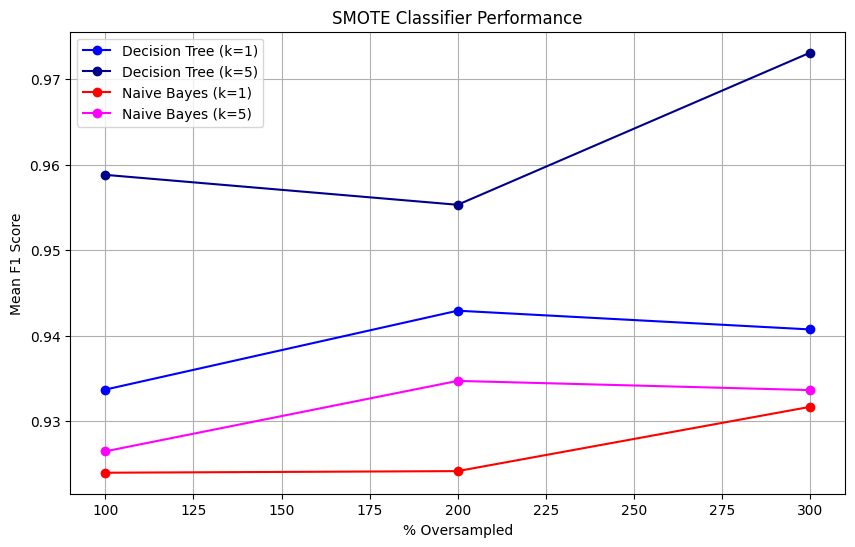

In [34]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

oversampling_percentages = [1.0, 2.0, 3.0]
k_values = [1, 5]
dec_tree_f1_scores_k1 = []
nb_f1_scores_k1 = []
dec_tree_f1_scores_k5 = []
nb_f1_scores_k5 = []

def smote_eval(X_train, y_train, X_test, y_test, k_neighbors, oversample_pct):

    X_train_resampled, y_train_resampled = smote(X_train, y_train, min_class=1, oversample_pct=oversample_pct, k=k_neighbors)

    #initialize and evaluate our DT classifier using SMOTE
    dec_tree = DecisionTreeClassifier(maximum_tree_depth=5)
    dec_tree_mean_f1, _ = test_performance(dec_tree, X_train_resampled, y_train_resampled,10)

    #initialize and evaluate our NB classifier using SMOTE
    nb = NaiveBayesClassifier()
    nb_mean_f1, _ = test_performance(nb, X_train_resampled, y_train_resampled,10)

    return dec_tree_mean_f1, nb_mean_f1

#for each of our oversampling percentages, we evaluate our classifiers using SMOTE at KNN of 1 and 5
for pct in oversampling_percentages:

    dec_tree_f1_k1, nb_f1_k1 = smote_eval(X_train, y_train, X_test, y_test, k_neighbors=1, oversample_pct=pct)
    dec_tree_f1_scores_k1.append(dec_tree_f1_k1)
    nb_f1_scores_k1.append(nb_f1_k1)
    
    dec_tree_f1_k5, nb_f1_k5 = smote_eval(X_train, y_train, X_test, y_test, k_neighbors=5, oversample_pct=pct)
    dec_tree_f1_scores_k5.append(dec_tree_f1_k5)
    nb_f1_scores_k5.append(nb_f1_k5)

plt.figure(figsize=(10, 6))
plt.plot([100, 200, 300], dec_tree_f1_scores_k1, label='Decision Tree (k=1)', marker='o', color='blue')
plt.plot([100, 200, 300], dec_tree_f1_scores_k5, label='Decision Tree (k=5)', marker='o', color='darkblue')
plt.plot([100, 200, 300], nb_f1_scores_k1, label='Naive Bayes (k=1)', marker='o', color='red')
plt.plot([100, 200, 300], nb_f1_scores_k5, label='Naive Bayes (k=5)', marker='o', color='magenta')
plt.xlabel('% Oversampled')
plt.ylabel('Mean F1 Score')
plt.title('SMOTE Classifier Performance')
plt.legend()
plt.grid(True)
plt.show()


We can see some interesting patterns revealed when looking at our classifiers' performance using the SMOTE technique. First, it appears that the Decision Tree classifier takes very well to oversampling with additional synthetic data.  As seen from chart, Decision Tree classifier performs better at all quantifications of kNeighbor and all sampling percentages than it does without any type of oversampling.  It performs best at 300% oversampling - indicating that more synthetic samples may increase the model's overall performance.
<br><br>
The NB classifier also seems to slightly increase in mean F1 score as oversampling percentage is increased. However, it does not have same drastic model impact as it did with the Decision Tree classifier.  We may want to try oversampling at even higher percentages to see if we can further improve the peformance of the NB model.